# Exploring Echoregions Lines Functionality

This notebook parses bottom values from an Echoview `.evl` file and create a bottom mask for the corresponding sonar data.

### Installation

Prior to running this notebook and all other notebooks, make sure to pip install Echoregions and Echopype Plotting Library.

Install Using PyPi:

`pip install echoregions`

`pip install echopype[plot]`

Install Using Latest Github Main Branch Commit:

`pip install git+https://github.com/OSOceanAcoustics/echoregions.git`

`pip install git+https://github.com/OSOceanAcoustics/echopype.git@plot`

In [38]:
# Importing Packages
import matplotlib.pyplot as plt
import urllib.request
import shutil
import xarray as xr
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from echopype.visualize.cm import cmap_d

import echoregions as er

### Bottom Data Reading

To start this tutorial, we first download EVL data from Echoregion's github repository and parse the EVL file using Echoregion's `read_evl` function. 

The parsing is based off of the EVL data description shown on Echoview's website: [Line Attributes](https://support.echoview.com/WebHelp/Using_Echoview/Exporting/Exporting_Data/Exporting_line_data.htm).

In [39]:
# Set path to test data
TEST_DATA_PATH = 'https://raw.githubusercontent.com/OSOceanAcoustics/echoregions/update_notebook_docs_base_main/echoregions/test_data'

# Download example EVL File
urllib.request.urlretrieve(f"{TEST_DATA_PATH}/transect.evl","transect.evl")

# Read EVL file
lines = er.read_evl('transect.evl')

#### Lines as a DataFrame

`lines` is a specialized object but it has a `data` attribute which is a simple dataframe.

In [40]:
# Grab lines dataframe
lines_df = lines.data

In [41]:
lines_df

,file_name,file_type,evl_file_format_version,echoview_version,time,depth,status
0,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 18:39:41.321000,442.996834,3
1,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 18:39:42.679000,437.818405,3
2,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 18:39:44.031000,445.194735,1
3,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 18:39:45.380000,451.168987,3
4,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 18:39:46.728000,442.551006,3
...,...,...,...,...,...,...,...
3166,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 21:04:47.146000,760.707803,3
3167,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 21:04:47.147000,762.196532,3
3168,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 21:10:40.095000,766.613696,3
3169,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 21:10:40.096000,763.976879,3


Note the rightmost column status. Status values are generally described by the following:

0 = none

1 = unverified

2 = bad

3 = good

The good and bad values are assigned via the specific EVL line picking formula used to generate the initial EVL file. Generally, we only want the rows with good/3 status.

More information on Echoview Status can be found here: https://support.echoview.com/WebHelp/Using_Echoview/Echogram/Lines/About_Line_Status.htm.

Let's now plot good points.

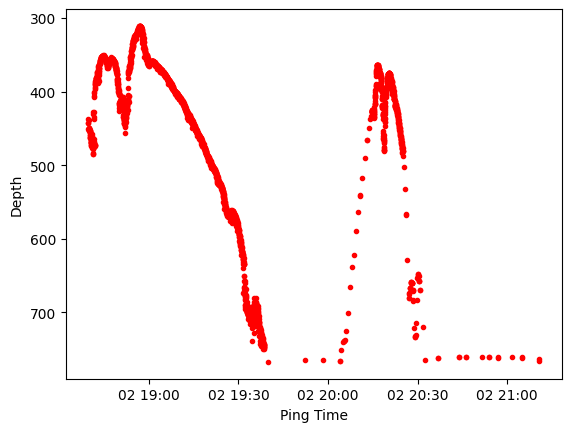

In [42]:
# Status 3 are good points so we select those
good_lines_df = lines_df[lines_df['status'] == '3']
good_bottom = good_lines_df[['time', 'depth']]

plt.plot(good_bottom['time'], good_bottom['depth'], 'r.')
plt.xlabel('Ping Time')
plt.ylabel('Depth')
plt.gca().invert_yaxis()

plt.show()

For usage later on, set this good dataframe as the current line dataframe:

In [43]:
lines.data = good_lines_df

### Sonar Data Reading and Plotting

Let's now download and plot some Sonar backscatter data created using [Echopype](https://echopype.readthedocs.io/en/stable/). Echopype is a sonar backscatter parsing and scientific computation software for which Echoregions (a sonar annotation parsing software) is built to be used in conjunction with. For now, we will primarily be working with the `ds_Sv["Sv"]` backscatter volume data variable, but there are many more data variables that can be used when parsing with Echopype.

In [44]:
# Download example Echopype Sonar Zarr File
urllib.request.urlretrieve(f"{TEST_DATA_PATH}/transect.zip","transect.zip")

# Extract the ZIP file
shutil.unpack_archive("transect.zip", "")

# Read EVL file
ds_Sv = xr.open_dataset('transect.zarr', engine="zarr")

In [45]:
ds_Sv["Sv"]

<xarray.DataArray 'Sv' (depth: 3955, ping_time: 1681, channel: 3)>
[19945065 values with dtype=float64]
Coordinates:
  * channel       (channel) <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11' ... '...
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    range_sample  (depth) int64 ...
Attributes:
    actual_range:  [-156.0, 37.68]
    long_name:     Volume backscattering strength (Sv re 1 m-1)
    units:         dB

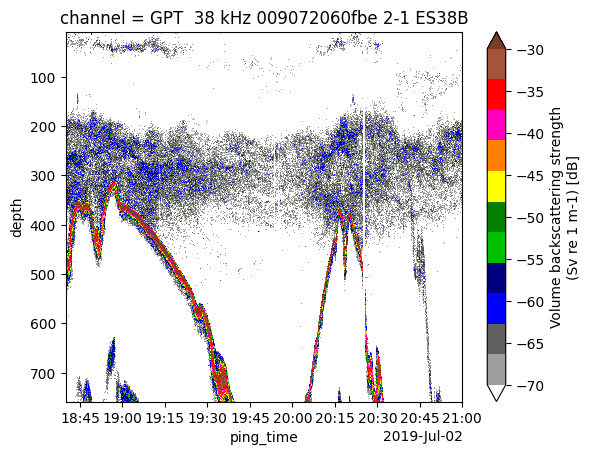

In [63]:
# Plot the 38 kHz backscatter channel
ds_Sv["Sv"].isel(channel=1).plot.pcolormesh(y="depth", yincrease=False, vmin=-70, vmax=-30, cmap=cmap_d["ek500"])

### Plotting and Masking Sonar and Bottom

From the two previous plots, one can kind of see how they're related on both the depth and time dimensions. Now let's see bottom annotations overlayed on top of the Sonar dataset.

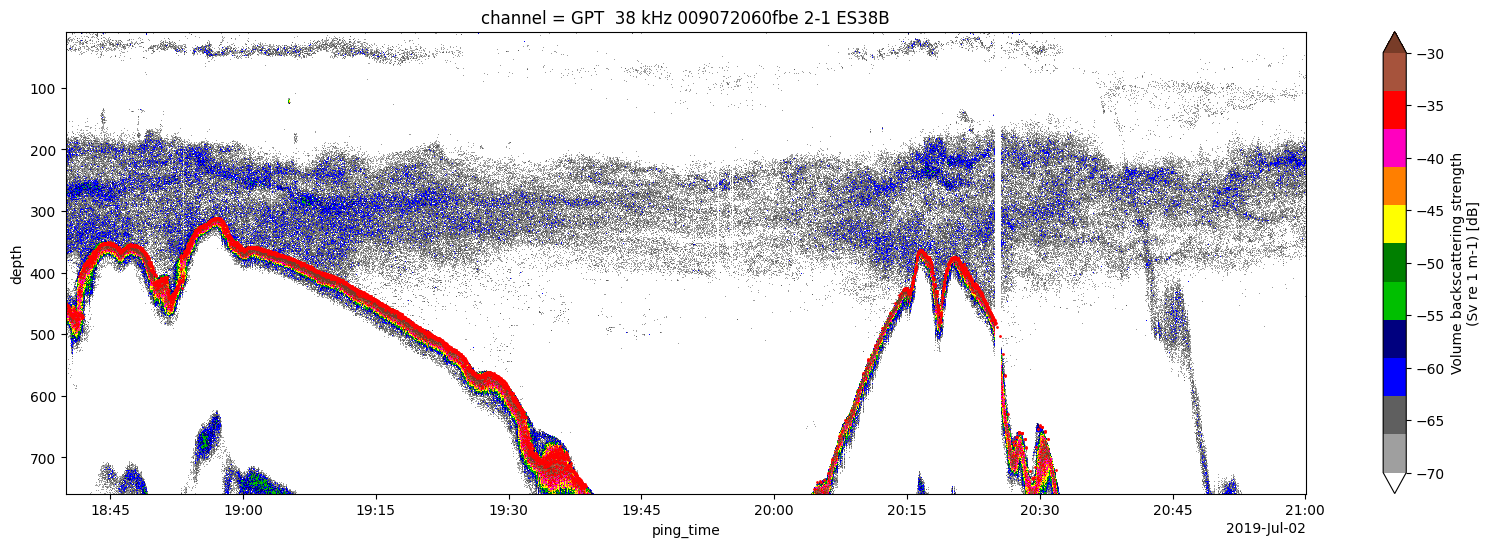

In [64]:
# Plotting the sonar data and the bottom
plt.figure(figsize = (20, 6))
plt.plot(lines.data['time'], lines.data['depth'],'ro',fillstyle='full', markersize=1)
ds_Sv.Sv.isel(channel=1).T.plot.pcolormesh(y="depth", yincrease=False, vmin=-70, vmax=-30, cmap=cmap_d["ek500"])

We can see that there is clear overlap between the two pieces of data here. However, for machine learning training purposes, or for biomass estimation, it is necessary to mask out the pixels below the bottom line.

The `Lines` class has a function to do this specific task: `mask`. The `mask` function interpolates the bottom points found in the DataFrame to generate new bottom points, and from these new points, generates an xarray bottom mask. There are a few different Pandas interpolation schemes one can pass in, but for this example we stick with something simple `slinear` which refers to a first order spline.

In [48]:
# Use the built in mask function
bottom_mask_da, bottom_contours = lines.mask(
    ds_Sv["Sv"].isel(channel=1).drop_vars("channel").compute(),
    method="slinear",
    limit_area=None,
    limit_direction="both"
)

Note that selecting 1 channel here is to ensure that our output is a single channel mask. The number of channels of the data array that is passed into the mask will match the number of channels of the output bottom mask data array.

The output should be both the bottom mask itself and interpolated points that constitute the bottom mask.

Let's take a look at the mask `bottom_mask_da` first:

In [49]:
bottom_mask_da

<xarray.DataArray (depth: 3955, ping_time: 1681)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])
Coordinates:
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 0 3 4 5 6 7 8 ... 3951 3952 3953 3954 3955 3956
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...

The values in the bottom mask should also just be 1s (at and below bottom) and 0s (above bottom):

In [50]:
print("Unique Values in Bottom Mask:", np.unique(bottom_mask_da.data))

Unique Values in Bottom Mask: [0 1]


As a sanity check, let us check that the `ping_time` and `depth` dimensions in the bottom mask `bottom_mask_da` are equal to that in the backscatter sonar data `ds_Sv["Sv"]`:

In [51]:
print(
    "Bottom Mask Ping Time Dimension Length:",
    len(bottom_mask_da["ping_time"])
)
print(
    "Bottom Mask Depth Dimension Length:",
    len(bottom_mask_da["depth"])
)
print(
    "Backscatter Sonar Ping Time Dimension Length:",
    len(ds_Sv["Sv"]["ping_time"])
)
print(
    "Backscatter Sonar Depth Dimension Length:",
    len(ds_Sv["Sv"]["depth"])
)

Bottom Mask Ping Time Dimension Length: 1681
Bottom Mask Depth Dimension Length: 3955
Backscatter Sonar Ping Time Dimension Length: 1681
Backscatter Sonar Depth Dimension Length: 3955


A plot of the mask itself:

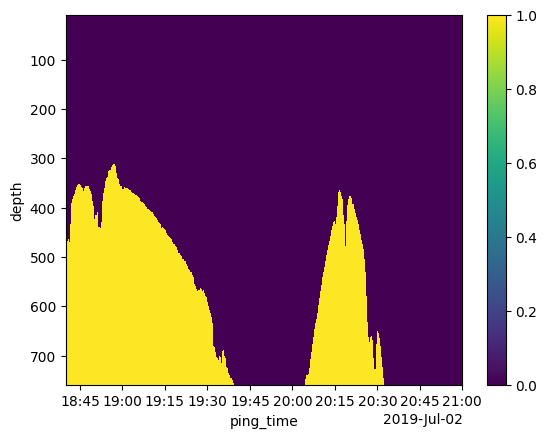

In [59]:
bottom_mask_da.plot(y="depth", yincrease=False)

A plot of the 38 kHz channel where the mask is 1:

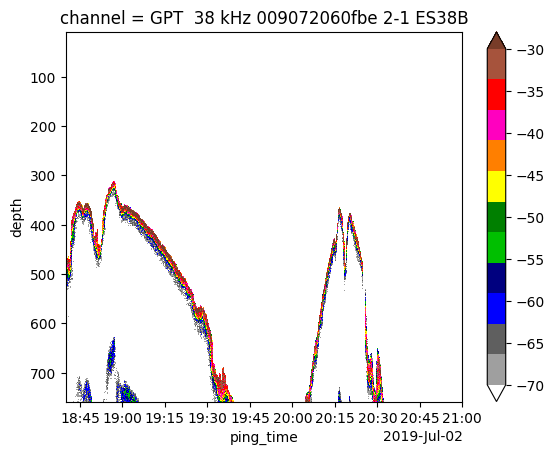

In [60]:
# Get only 38 kHz channel values where the mask is 1
mask_exists_Sv = xr.where(
    bottom_mask_da == 1,
    ds_Sv["Sv"].isel(channel=1),
    np.nan,
)

# Plot the masked Sv
mask_exists_Sv.plot.pcolormesh(y="depth", yincrease=False, vmin=-70, vmax=-30, cmap=cmap_d["ek500"])

Let's now take a look at the interpolated points `bottom_contours`:

Let's compare its number of rows to the number of rows from the lines dataframe it was created from.

In [54]:
print("Interpolated Rows:", len(bottom_contours))
print("Original Rows:", len(lines.data))

Interpolated Rows: 1681
Original Rows: 2756


Why are there more rows in the original rows than there are in the intepolated rows? It's because the interpolated bottom data has to match the ping time dimension of the passed in dataset.

Let's now look at the sonar ping time dimension length:

In [55]:
print("Sonar Ping Time Dimension Length:", len(ds_Sv["ping_time"]))

Sonar Ping Time Dimension Length: 1681


Let's now plot original bottom points vs interpolated points:

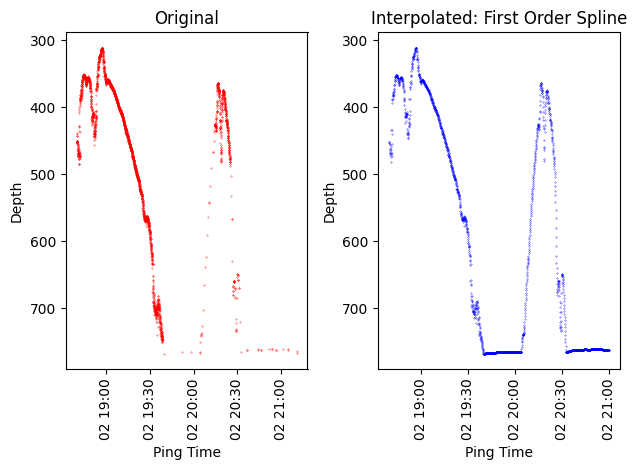

In [56]:
# Plot both original and interpolated
plt.subplot(1, 2, 1)
plt.plot(lines.data['time'], lines.data['depth'], 'r.', markersize=0.5)
plt.gca().invert_yaxis()
plt.title('Original')
plt.xticks(rotation=90)
plt.xlabel('Ping Time')
plt.ylabel('Depth')
plt.subplot(1, 2, 2)
plt.plot(bottom_contours['time'], bottom_contours['depth'], 'b.', markersize=0.5)
plt.gca().invert_yaxis()
plt.title('Interpolated: First Order Spline')
plt.xticks(rotation=90)
plt.xlabel('Ping Time')
plt.ylabel('Depth')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Let's now look at a 30 minute subset of original and interpolated data between 2019-07-02 19:25:00 and 2019-07-02 19:55:00:

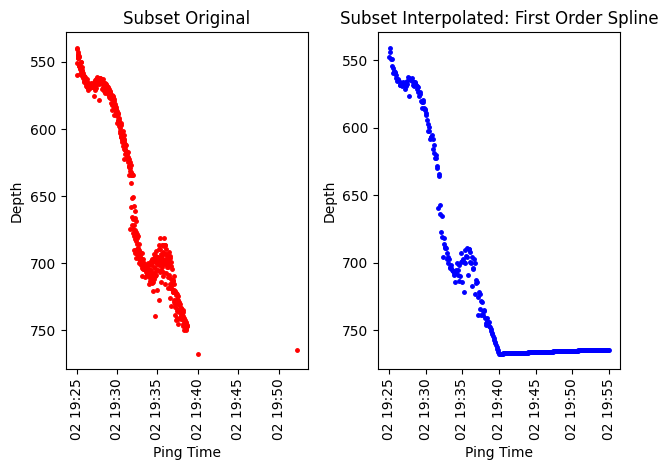

In [57]:
# Filter the DataFrames based on time range
start_time = pd.to_datetime('2019-07-02 19:25:00')
end_time = pd.to_datetime('2019-07-02 19:55:00')
subset_lines_data = lines.data[(lines.data['time'] >= start_time) & (lines.data['time'] <= end_time)]
subset_bottom_contours = bottom_contours[(bottom_contours['time'] >= start_time) & (bottom_contours['time'] <= end_time)]

# Plot both original and interpolated
plt.subplot(1, 2, 1)
plt.plot(subset_lines_data['time'], subset_lines_data['depth'], 'r.', markersize=5)
plt.gca().invert_yaxis()
plt.title('Subset Original')
plt.xticks(rotation=90)
plt.xlabel('Ping Time')
plt.ylabel('Depth')
plt.subplot(1, 2, 2)
plt.plot(subset_bottom_contours['time'], subset_bottom_contours['depth'], 'b.', markersize=5)
plt.gca().invert_yaxis()
plt.title('Subset Interpolated: First Order Spline')
plt.xticks(rotation=90)
plt.xlabel('Ping Time')
plt.ylabel('Depth')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Note that `ds_Sv` is the entire dataset containing many data variables that Echoregions does not work with, and so passing in the entire dataset to Echoregions `lines.mask` will produce an error since it expects a single data array `ds_Sv["Sv"]`:

In [58]:
# Test ds_Sv
lines.mask(
    ds_Sv,
    method="slinear",
    limit_area=None,
    limit_direction="both"
)

TypeError: Input da_Sv must be of type DataArray. da_Sv was instead of type <class 'xarray.core.dataset.Dataset'>

### Saving to .csv and Reading From .csv

So now that we have our mask and our new interpolated bottom points, how do we save them?

We can use the Echoregions `read_lines_csv` function to first load it onto a lines object and use the lines object's `to_csv` function to save the lines dataframe as a `.csv`.

In [ ]:
# Create new lines object
from_mask_lines = er.read_lines_csv(bottom_contours)

# Save to .csv
from_mask_lines.to_csv("from_mask_lines.csv")

Now if you need to load this `.csv` into a lines object we can again use `read_lines_csv` since it takes in both file locations (Path/str objects) and Pandas DataFrames:

In [ ]:
# Create another new lines object
from_csv_lines = er.read_lines_csv("from_mask_lines.csv")

Now let's check if these dataframes are equal:

In [ ]:
try:
    assert_frame_equal(from_mask_lines.data, from_csv_lines.data)
    print("The two DataFrames are equal.")
except AssertionError:
    print("The two DataFrames are not equal.")

The two DataFrames are not equal.
